In [11]:
import os
import ast
import math
import pandas as pd
import geopandas as gpd 
import numpy as np
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import ee
import geemap.foliumap
import eeconvert

ee.Initialize()

pd.set_option('display.max_columns', None)
sns.set()
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
import gee_tools.datasources.sentinel2 as opt_s2
from gee_tools.imgtools import getScaledImage
from gee_tools.harmonics import run_std_regressions

### Step 0: Survey data wrangling

In [4]:
# Dummy data for the purpose of demonstration
survey_df = pd.read_csv('data/0_survey_data/raw_survey.csv')

In [5]:
survey_df

,hh_id,plotid,crop,year,season,irrigation,fertilizer,planting_date,geom_poly
0,hh_01,pl_1,maize,2019,rainy,no,NaN,NaN,"{""type"":""Polygon"",""coordinates"":[[[33.17239286..."
1,hh_02,pl_2,maize_hybrid,2019,rainy,NaN,60.0,NaN,"{""type"":""Polygon"",""coordinates"":[[[33.15676095..."
2,hh_03,pl_3,rice,2019,rainy,yes,50.0,21-May,"{""type"":""Polygon"",""coordinates"":[[[33.16654564..."
3,hh_04,pl_4,sorghum,2019,rainy,NaN,NaN,NaN,"{""type"":""Polygon"",""coordinates"":[[[33.16905619..."
4,hh_05,Pl_5,beans,2019,rainy,NaN,30.0,April,"{""type"":""Polygon"",""coordinates"":[[[33.14849974..."


In [6]:
survey_df['geom_poly'][0]

'{"type":"Polygon","coordinates":[[[33.17239286542065,-13.90195782152107],[33.17355157971508,-13.902166112825665],[33.17391636014111,-13.89804191011496],[33.17262889981396,-13.897958592131438],[33.17239286542065,-13.90195782152107]]]}'

In [7]:
# clean geometry column 
survey_df['geom_poly'] = survey_df.apply(lambda row: ast.literal_eval(row['geom_poly']), axis=1)
survey_df['geom_poly'] = survey_df.apply(lambda row: Polygon(row['geom_poly']['coordinates'][0]), axis=1)
survey_df = survey_df.rename(columns={'geom_poly': 'geometry'})
survey_df

,hh_id,plotid,crop,year,season,irrigation,fertilizer,planting_date,geometry
0,hh_01,pl_1,maize,2019,rainy,no,NaN,NaN,POLYGON ((33.17239286542065 -13.90195782152107...
1,hh_02,pl_2,maize_hybrid,2019,rainy,NaN,60.0,NaN,POLYGON ((33.15676095128185 -13.89990093482503...
2,hh_03,pl_3,rice,2019,rainy,yes,50.0,21-May,POLYGON ((33.16654564976818 -13.90262956030594...
3,hh_04,pl_4,sorghum,2019,rainy,NaN,NaN,NaN,POLYGON ((33.16905619740612 -13.90460831438962...
4,hh_05,Pl_5,beans,2019,rainy,NaN,30.0,April,POLYGON ((33.14849974751599 -13.89821375336131...


In [8]:
# convet to geodataframe
survey_gdf = gpd.GeoDataFrame(survey_df, geometry='geometry')
survey_gdf['geom_id'] = survey_gdf['hh_id'] + '_' + survey_gdf['plotid']

# clean crop names
survey_gdf['croptype_str'] = 'other'
survey_gdf.loc[survey_gdf['crop'].str.contains('maize'), 'croptype_str'] = 'maize'

In [9]:
# select desired columns and write file
survey_gdf = survey_gdf[['geom_id', 'year', 'croptype_str', 'geometry']]
survey_gdf.to_file("data/0_survey_data/survey_clean.gpkg")

### Step 1: Generating features

##### We use harmonic regressions to characterize crop phenology

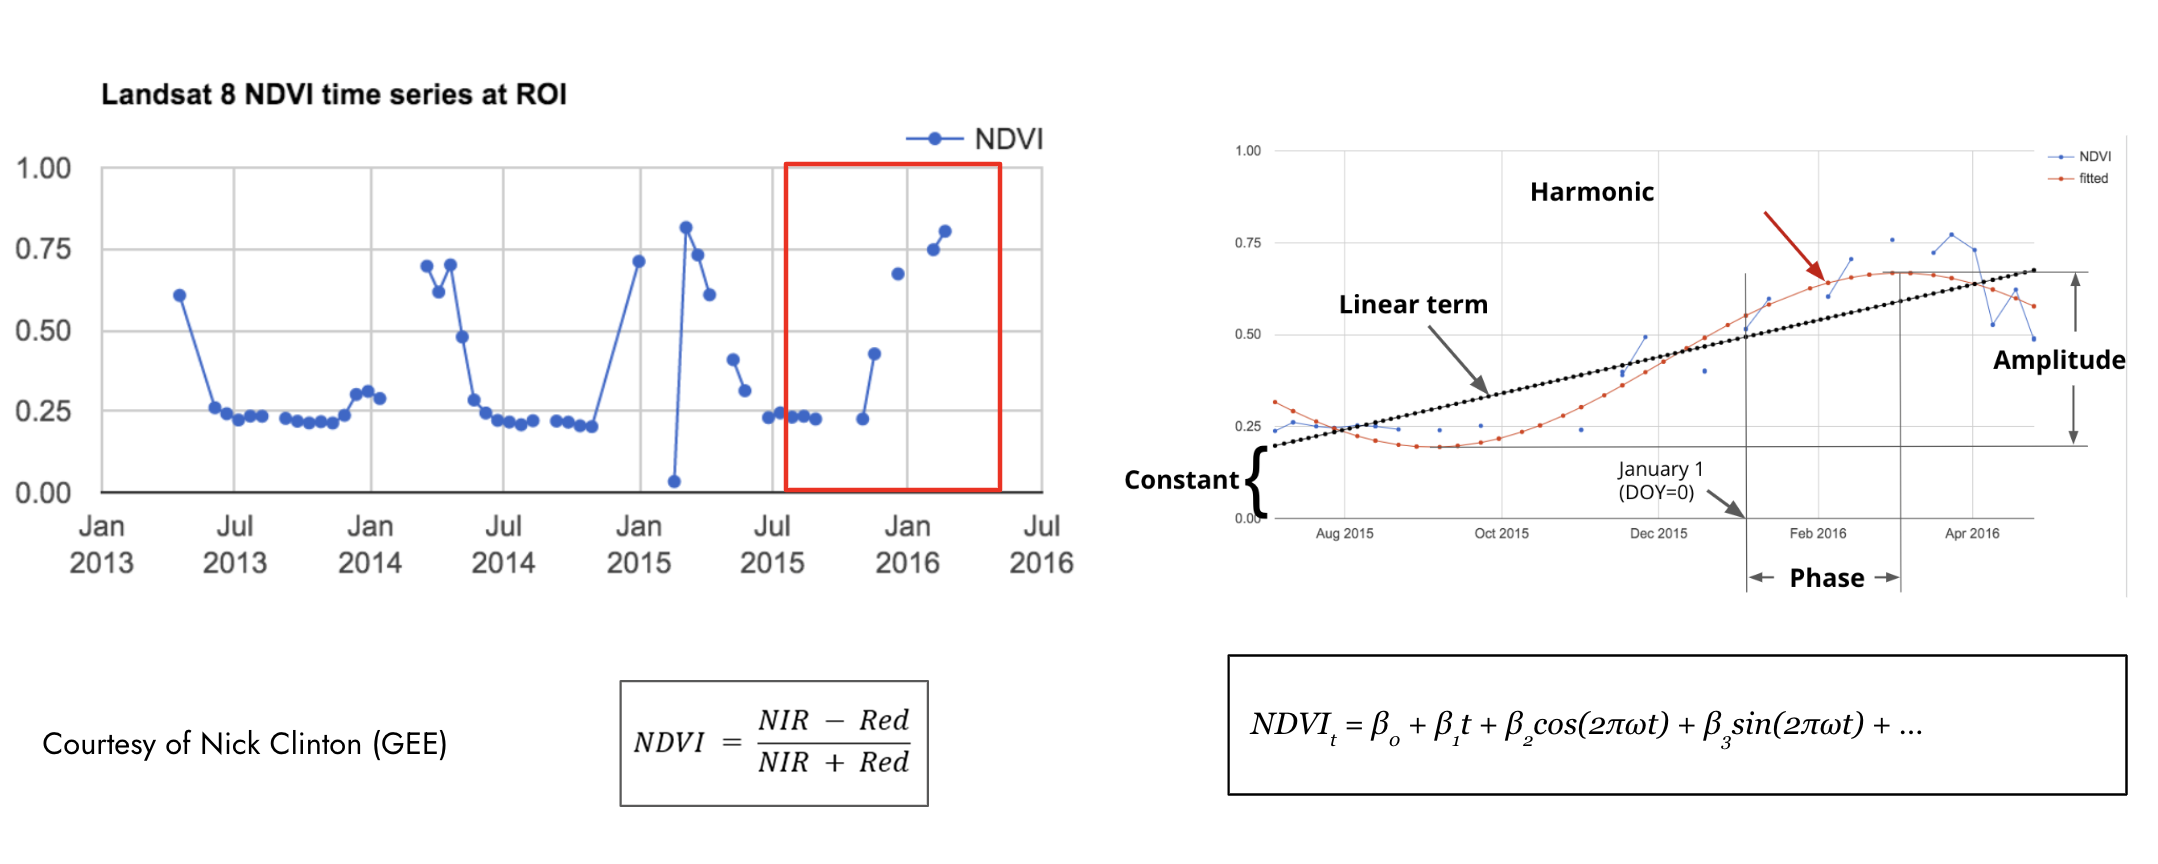

In [12]:
# selecting a small geometry for demonstration purposes
roi = ee.Geometry.Polygon([[33.13382026557807,-13.923324245171836],
                           [33.17873602978405,-13.923324245171836],
                           [33.17873602978405,-13.87972406080146],
                           [33.13382026557807,-13.87972406080146], 
                           [33.13382026557807,-13.923324245171836]])

In [13]:
# convert to feature collection
survey_fc = eeconvert.gdfToFc(survey_gdf)

In [26]:
# visualize ROI
Map = geemap.foliumap.Map()

Map.add_basemap('SATELLITE')
Map.addLayer(roi, {}, 'roi')
Map.addLayer(survey_fc, {'color':'F1216D'}, 'fields')
Map.centerObject(roi)
Map

#### 1.1 Obtaining desired time series satellite data from GEE

In [15]:
# Here we will make use of some of our orgaizations code which is publicly available, 
# i.e. the gee-tools module installed previously in our virtual environment

# start and end dates have been chosen to center the year around the middle of season (information from FAO)
# season of interest is 2018/19
start_date = ee.Date('2018-08-28')
end_date = ee.Date('2019-08-27')

s2coll = opt_s2.Sentinel2TOA(filterpoly=roi, start_date=start_date, end_date=end_date, 
                            addVIs=True, addCloudMasks=True).get_img_coll()

In [16]:
# function to mask clouds using decision tree classifier band
def maskClouds_toa(img):
    fse = img.select(['QA_FSEV1'])
    clear = fse.updateMask(fse.eq(1))
    return img.updateMask(clear)

# Define the bandames in the S2-2A data which we want to keep
bandnames = ['AEROS','BLUE','GREEN','RED','RDED1','RDED2','RDED3','NIR','RDED4',
             'VAPOR','SWIR1','SWIR2','NBR1','NDTI','GCVI','NDVI','SNDVI']
# Mask clouds using the function above
s2coll = s2coll.map(lambda img: maskClouds_toa(img))

In [17]:
s2_proj = (
    ee.Image(ee.ImageCollection("COPERNICUS/S2").first())
    .select("B3")
    .reproject("EPSG:3857")
    .projection()
)
s2coll = s2coll.map(lambda img: img.select(bandnames).setDefaultProjection(crs=s2_proj, scale=10))

In [18]:
# check bands
for band in s2coll.first().getInfo()['bands']:
    print(band['id'])

AEROS
BLUE
GREEN
RED
RDED1
RDED2
RDED3
NIR
RDED4
VAPOR
SWIR1
SWIR2
NBR1
NDTI
GCVI
NDVI
SNDVI


#### 1.2 Harmonic curve fitting over time series data - An example

In [19]:
omega = 1.2
nharmonics = 2

In [20]:
# function of fourier series
def fourier(t, *coeffs):
    gcvi_fit = coeffs[0] + coeffs[1] * t
    for n in range(nharmonics):
        timerad = t * 2 * (n+1) * np.pi * omega
        gcvi_fit += coeffs[2 + n*2] * np.cos(timerad) + coeffs[3 + n*2] * np.sin(timerad)
    return gcvi_fit

# adding a row for each day of the year
def gen_dates():
    start_date = '28/08/2018'
    end_date = '27/08/2019'
    rng = pd.date_range(start=start_date, end=end_date)
    df = pd.DataFrame({ 'DATE': rng})
    df['t'] = df['DATE'] - datetime.strptime(start_date, '%d/%m/%Y')
    df['t'] = df["t"] / (datetime.strptime(end_date, '%d/%m/%Y') - datetime.strptime(start_date, '%d/%m/%Y'))
    return df

def clean_ts(df):
    df['DATE'] = pd.to_datetime(pd.to_datetime(df['DATE'], format='%Y-%m-%dT%H:%M:%S').dt.strftime('%Y-%m-%d'))
    df = df.drop_duplicates(['DATE'])
    master_df = gen_dates()
    df = master_df.merge(df, on='DATE', how='outer')
    df['t'] = df['t_y']
    df.loc[df['t'].isnull(),'t'] = df.loc[df['t'].isnull(), 't_x'] 
    df = df.sort_values(by=['DATE'])
    return df[['DATE', 'GCVI', 't']]

def fit_ts(df):
    df = clean_ts(df)
    popt, pcov = curve_fit(fourier, df[~df['GCVI'].isnull()]['t'],
                           df[~df['GCVI'].isnull()]['GCVI'], [1, 1] + [1, 1]*nharmonics)
    df['GCVI_HARMFIT'] = fourier(df['t'], *popt)
    return df

# example time series for 3 different crops
maize_ts = pd.read_csv('data/1_satellite_features/maize_ts.csv')
groundnut_ts = pd.read_csv('data/1_satellite_features/groundnut_ts.csv')
soyabean_ts = pd.read_csv('data/1_satellite_features/soyabean_ts.csv')

maize_ts = fit_ts(maize_ts)
groundnut_ts = fit_ts(groundnut_ts)
soyabean_ts = fit_ts(soyabean_ts)

/Users/shruti/anaconda3/envs/ct_map/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  if sys.path[0] == '':


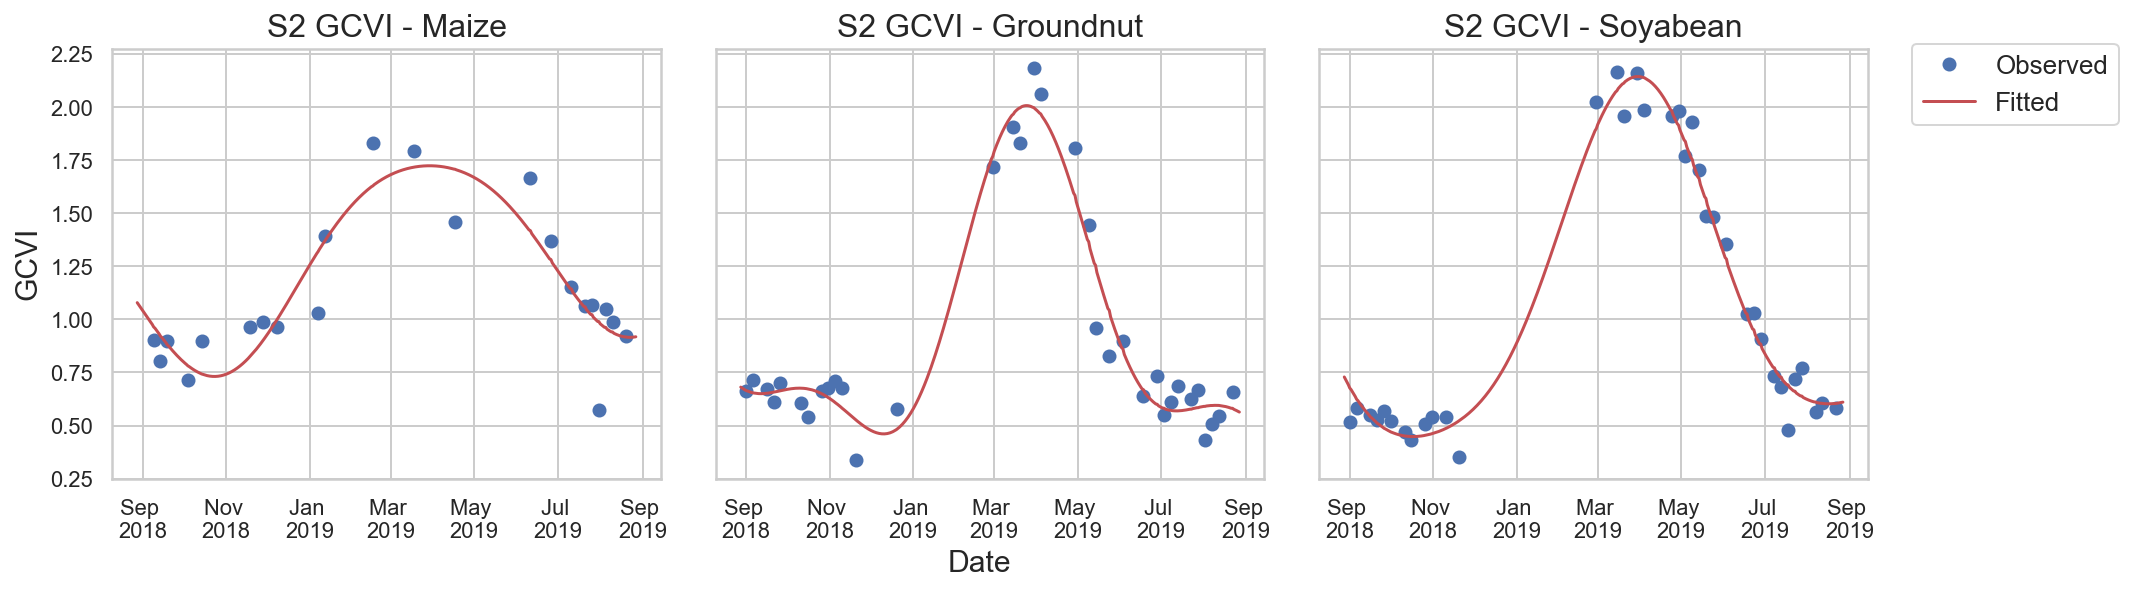

In [21]:
# the peaks look lower as we haven't applied any correction (top of atmosphere to surface reflectance) here

dfs = [maize_ts, groundnut_ts, soyabean_ts]
crops = ['Maize', 'Groundnut', 'Soyabean']

sns.set_style("whitegrid")
sns.set_palette("bright")

fig, ax = plt.subplots(1, 3, figsize=(13,4), sharex=True, sharey=True, constrained_layout=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(b=None)
plt.xlabel('Date', fontsize=15)
plt.ylabel('GCVI', fontsize=15)

axs = ax.flatten()

for n in range(len(dfs)):
    df = dfs[n]
    p1,  = axs[n].plot_date(df['DATE'], df['GCVI'], c='b')
    axs[n].set_xlabel(' ', fontsize=15)
    axs[n].set_ylabel(' ', fontsize=15)
    p2, = axs[n].plot(df['DATE'], df['GCVI_HARMFIT'], c='r')
    axs[n].xaxis.set_major_formatter(mdates.DateFormatter('%b \n%Y'))
    ax[n].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    axs[n].set_title('S2 GCVI - {}'.format(crops[n]), fontsize=16)
    
plt.figlegend((p1, p2), ('Observed', 'Fitted'), bbox_to_anchor=(1.01,0.96), loc='upper left', prop={"size":13})
plt.show()

#### 1.3 Harmonic exports

In [22]:
# now we need to repeat the above to obtain and export the harmonic coefficients 
# for all pixels in our ROI. GEEs parallel processing comes in handy here
# We are computing harmonics over GCVI only, but the same process can be used for other bands/VIs of interest 

slhr = run_std_regressions(imagecoll=s2coll, bands=['GCVI'], refdate=start_date, independents=None, 
                           omega=1.2, nharmonics=2)

# Convert to int32 to save some storage. scaling count differently as it may break Int32 limits.
scaler = ee.Dictionary.fromLists(
    slhr.bandNames().removeAll([f"GCVI_count"]),
    ee.List.repeat(1e7, slhr.bandNames().length().subtract(1))
    ).combine(ee.Dictionary({
        f"GCVI_count": 1,
    })
) 

slhr = getScaledImage(slhr, scaler).toInt32().set(scaler)  

slhr = slhr.set(
    'omega', omega,
    'bands', ['GCVI'],
    'nharmonics', nharmonics,
    'start_date', ee.Date(start_date).format(),
    'end_date', ee.Date(end_date).format(),
    'start_ms', ee.Date(start_date).millis(),
    'end_ms', ee.Date(end_date).millis(),
    'year', 2019)

In [23]:
# Export coefficients to GEE asset library 
task = ee.batch.Export.image.toAsset(
    image=slhr.clip(roi), 
    description='exporting_gcvi_coeffs', 
    assetId='users/shruti/cega_geo4dev/gcvi_harmonic_coeffs', ### change this path if you want to export
                                                              ### this to your GEE library 
                                                              ### (make sure the folder you're exporting to exists) 
    region=roi, 
    scale=10
)

task.start()

#### 1.4 VIsualizing the coefficients

In [24]:
def get_phase_ampl(harmcoeffs, band):
    cosname = band+'_cos1'
    sinname = band+'_sin1'
    constant = band+'_constant' 
    
    # Compute phase and amplitude.
    phase = harmcoeffs.select(cosname).atan2(
        harmcoeffs.select(sinname))
    amplitude = harmcoeffs.select(cosname).hypot(
        harmcoeffs.select(sinname))
    vertshift = harmcoeffs.select(constant)
    
    #Use the HSV to RGB transform to display phase and amplitude
    rgb = phase.unitScale(0, math.pi*0.5).addBands(
        amplitude.multiply(0.000001)).addBands(
        vertshift.multiply(0.0000001)).hsvToRgb();
    return rgb

In [25]:
gcvi_coeffs = ee.Image('users/shruti/cega_geo4dev/gcvi_harmonic_coeffs')

rgb = get_phase_ampl(gcvi_coeffs, 'GCVI');
Map = geemap.foliumap.Map()
Map.setOptions('SATELLITE');
Map.addLayer(rgb, {}, 'Phase amplitude - GCVI - 2019');

Map.centerObject(gcvi_coeffs)
Map

### Step 2: Generating composites

In [27]:
# define a function to compute aggregates of satellite features over polygon geometries
def reduce_img_reg(f, img, red, prop_names=None, geo=False):
    props = img.reduceRegion(
      reducer=red,
      geometry=f.geometry(),
      scale=10
    )
    if geo:
        return ee.Feature(ee.Geometry(f.geometry()).centroid(), 
                          props).copyProperties(f, prop_names).copyProperties(img, None, img.bandNames())
    return ee.Feature(None, props).copyProperties(f, prop_names).copyProperties(img, None, img.bandNames())

In [28]:
poly_means = ee.FeatureCollection(survey_fc.map(
    lambda f: reduce_img_reg(f, gcvi_coeffs, ee.Reducer.mean(), 
                             ['geom_id', 'year', 'croptype_str', 'geometry'], True)))

In [29]:
# Export composites to a google drive folder 
task = ee.batch.Export.table.toDrive(
    poly_means, 'gcvi_composites', '2_composites'
)

task.start()

### You will need to move the exported composites to the desired folder location inside the github repo.
### The above code will export the coefficients to your main drive folder.

In [30]:
# check the exported compoites
gcvi_composites = pd.read_csv('data/2_composites/gcvi_composites.csv')
gcvi_composites

,system:index,GCVI_constant,GCVI_cos1,GCVI_cos2,GCVI_count,GCVI_mean,GCVI_r2,GCVI_rmse,GCVI_sin1,GCVI_sin2,GCVI_t,GCVI_variance,croptype_str,end_date,end_ms,geom_id,nharmonics,omega,start_date,start_ms,year,.geo
0,0,1.454038e+07,-8.371680e+06,1.854869e+06,76.257737,9.627959e+06,8.975811e+06,2.038523e+06,-5.599457e+06,2.025134e+06,-1.861404e+06,4.149967e+06,maize,2019-08-27T00:00:00,1.566864e+12,hh_01_pl_1,2.0,1.2,2018-08-28T00:00:00,1.535414e+12,2019.0,"{""type"":""Point"",""coordinates"":[33.173128396466..."
1,1,8.936620e+06,-2.455082e+06,5.011567e+05,64.840661,8.486153e+06,9.120451e+06,9.736973e+05,-4.208050e+06,1.265893e+06,1.721280e+06,1.189179e+06,maize,2019-08-27T00:00:00,1.566864e+12,hh_02_pl_2,2.0,1.2,2018-08-28T00:00:00,1.535414e+12,2019.0,"{""type"":""Point"",""coordinates"":[33.157086105947..."
2,2,1.334086e+07,-8.924441e+06,2.708350e+06,73.839920,9.530495e+06,9.088763e+06,1.904451e+06,-5.338512e+06,2.837326e+06,5.865184e+05,3.926292e+06,other,2019-08-27T00:00:00,1.566864e+12,hh_03_pl_3,2.0,1.2,2018-08-28T00:00:00,1.535414e+12,2019.0,"{""type"":""Point"",""coordinates"":[33.166562404524..."
3,3,1.353212e+07,-5.175330e+06,-4.396485e+05,77.134834,9.964452e+06,9.146189e+06,1.665679e+06,-6.451393e+06,2.748717e+06,-2.411802e+06,3.228105e+06,other,2019-08-27T00:00:00,1.566864e+12,hh_04_pl_4,2.0,1.2,2018-08-28T00:00:00,1.535414e+12,2019.0,"{""type"":""Point"",""coordinates"":[33.168976534153..."
4,4,1.398733e+07,-2.556686e+06,-8.136107e+05,72.768000,1.394322e+07,8.862463e+06,1.880055e+06,-6.524679e+06,6.974574e+05,2.863906e+06,3.149390e+06,other,2019-08-27T00:00:00,1.566864e+12,hh_05_Pl_5,2.0,1.2,2018-08-28T00:00:00,1.535414e+12,2019.0,"{""type"":""Point"",""coordinates"":[33.148531811388..."


### Step 3: Training an ML model

##### Metrics

Accuracy measures the fraction of correct predictions to total predictions. An accuracy score of 1 represents perfect prediction, and 0 indicates completely wrong prediction. 

The Matthews correlation coefficient (MCC) evaluates performance on all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives). An MCC score of +1 represents a perfect prediction, 0 represents random prediction, and −1 an inverse prediction.

<div>
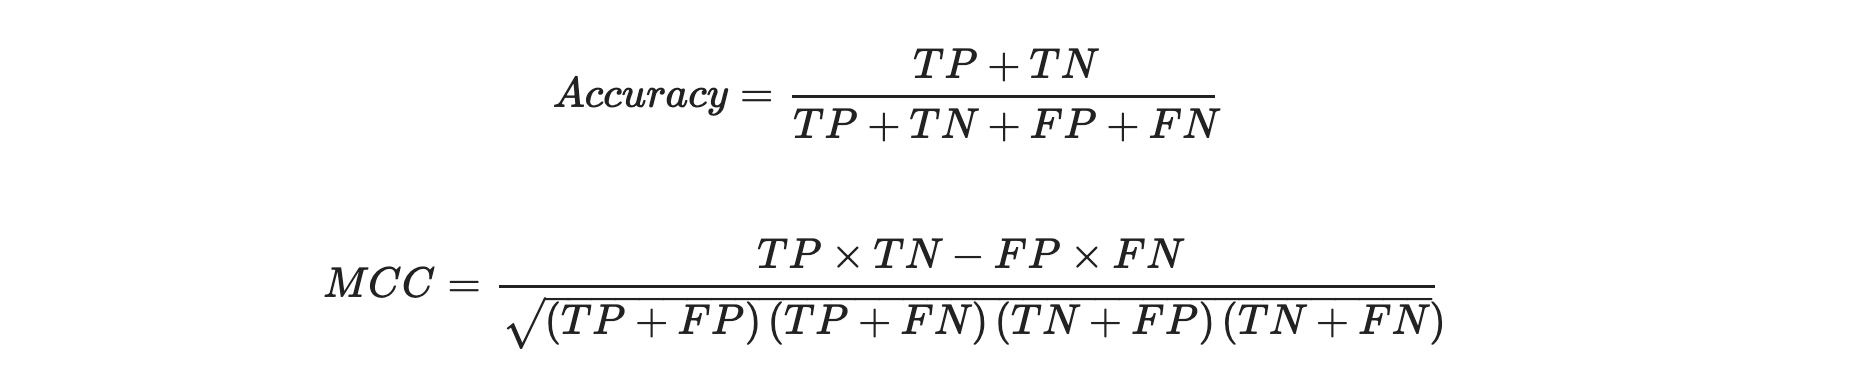
</div>

In [31]:
# Read feature-label composites provided in data folder
train_df = pd.read_csv('data/3_ml_model/training_data.csv')

In [32]:
train_df.head()

,GEOM_ID,YEAR,MAIZELAND,ASP,BLUE_constant,BLUE_cos1,BLUE_cos2,BLUE_mean,BLUE_r2,BLUE_rmse,BLUE_sin1,BLUE_sin2,BLUE_t,BLUE_variance,COUNT_s2,ELEV,GCVI_constant,GCVI_cos1,GCVI_cos2,GCVI_mean,GCVI_r2,GCVI_rmse,GCVI_sin1,GCVI_sin2,GCVI_t,GCVI_variance,GREEN_constant,GREEN_cos1,GREEN_cos2,GREEN_mean,GREEN_r2,GREEN_rmse,GREEN_sin1,GREEN_sin2,GREEN_t,GREEN_variance,NBR1_constant,NBR1_cos1,NBR1_cos2,NBR1_mean,NBR1_r2,NBR1_rmse,NBR1_sin1,NBR1_sin2,NBR1_t,NBR1_variance,NDTI_constant,NDTI_cos1,NDTI_cos2,NDTI_mean,NDTI_r2,NDTI_rmse,NDTI_sin1,NDTI_sin2,NDTI_t,NDTI_variance,NDVI_constant,NDVI_cos1,NDVI_cos2,NDVI_mean,NDVI_r2,NDVI_rmse,NDVI_sin1,NDVI_sin2,NDVI_t,NDVI_variance,NIR_constant,NIR_cos1,NIR_cos2,NIR_mean,NIR_r2,NIR_rmse,NIR_sin1,NIR_sin2,NIR_t,NIR_variance,Ptot,RDED4_constant,RDED4_cos1,RDED4_cos2,RDED4_mean,RDED4_r2,RDED4_rmse,RDED4_sin1,RDED4_sin2,RDED4_t,RDED4_variance,RED_constant,RED_cos1,RED_cos2,RED_mean,RED_r2,RED_rmse,RED_sin1,RED_sin2,RED_t,RED_variance,SLO,SNDVI_constant,SNDVI_cos1,SNDVI_cos2,SNDVI_mean,SNDVI_r2,SNDVI_rmse,SNDVI_sin1,SNDVI_sin2,SNDVI_t,SNDVI_variance,SWIR1_constant,SWIR1_cos1,SWIR1_cos2,SWIR1_mean,SWIR1_r2,SWIR1_rmse,SWIR1_sin1,SWIR1_sin2,SWIR1_t,SWIR1_variance,SWIR2_constant,SWIR2_cos1,SWIR2_cos2,SWIR2_mean,SWIR2_r2,SWIR2_rmse,SWIR2_sin1,SWIR2_sin2,SWIR2_t,SWIR2_variance,Tavg
0,65050,2019,0,306.236739,528178.1776,90086.8010,4100.358135,582484.5895,0.000,76131.17230,173639.72840,52293.82912,96604.004630,2575.542542,23.190459,532.294055,30963726.65,-5.843684e+06,-1.352605e+06,29367893.78,9284874.586,3126710.898,-1.593106e+07,4.623245e+04,-4818272.732,1.510712e+07,8.034497e+05,21003.62585,4905.827341,8.433110e+05,0.00,76227.50908,123560.51480,43582.34105,87166.52047,1433.302243,463273.58130,-7.633960e+05,55986.42755,4.021584e+05,9592590.693,278688.4838,-1.881155e+06,17033.86223,-334422.8765,216996.8683,2.555126e+06,-153446.3158,40588.19758,2.376836e+06,7184049.152,173673.6568,-755274.0135,146214.03950,-472168.73690,25617.79672,5859475.350,-8.087324e+05,-19735.69277,5916454.285,9468809.621,390322.8142,-2187971.305,-28332.01851,-1.769286e+05,307849.3300,3098372.347,-417895.8900,-56739.40869,3199624.732,8.787986e+06,238022.6846,-816850.95510,168196.96900,91178.61410,55190.46280,126446.0,3381615.891,-491078.8273,-20805.25525,3374126.497,8651731.802,237437.1363,-664232.46810,151849.15240,-24969.93094,44724.40370,7.858479e+05,101244.0110,27550.76646,7.832893e+05,0.000,90945.57351,328863.0039,14220.81737,41060.34069,7633.548950,2.742257,4161206.106,-6.743411e+05,-41553.41011,4234060.549,9539888.905,281657.0740,-1.692620e+06,47555.89747,-78489.34817,187369.92490,2780950.574,68921.26486,-31681.60591,2898062.780,0.000,189168.4001,338548.7052,92196.19331,256602.91310,9432.264507,1662812.244,83637.20826,-41004.889640,1813960.212,2.616401e+05,148482.6661,510695.9847,7949.12460,365843.3685,12057.98434,2815.000000
1,33403,2018,1,268.813534,520043.8741,111342.7888,21013.530470,521159.0788,282962.014,221801.46800,71160.93556,88514.38491,-68576.377910,10043.545810,70.529261,744.631374,25486566.75,-1.077294e+07,-1.489064e+06,21754300.26,7643107.011,5097889.490,-5.079846e+06,-1.855463e+06,-1838881.269,1.149109e+07,7.450565e+05,53446.10830,-3377.697969,7.672712e+05,368042.61,215185.22290,177906.13290,89198.87596,28043.30217,9447.385040,-56959.07265,-1.985843e+06,-130025.48820,-8.364843e+05,9104928.285,464348.5476,-5.787120e+05,-322787.50290,-488528.7580,254673.4002,2.343221e+06,-911974.2079,-98704.33284,1.836493e+06,8551323.751,292268.0755,-485077.8029,-107632.88650,-551467.84260,66399.16158,5081766.716,-2.279128e+06,-105880.62640,4167130.628,8612914.517,728993.6974,-1148340.699,-453623.60500,-6.750696e+05,416049.6623,2426125.673,-511884.1189,-85483.41141,2231211.655,5.421294e+06,308059.8758,200694.46290,-10712.59599,-49709.71438,25259.50491,67588.0,2629893.829,-614055.5825,-55031.32127,2386416.742,6830538.042,299476.4853,138177.70070,23692.22858,-112190.97010,28557.17409,8.017304e+05,305019.3358,-41975.73443,9.325906e+05,143

In [33]:
train_df = train_df.dropna().reset_index(drop=True)
train_df.shape

(1000, 129)

In [34]:
train_df['MAIZELAND'].value_counts()

1    716
0    284
Name: MAIZELAND, dtype: int64

In [35]:
X = train_df.drop(['GEOM_ID', 'MAIZELAND', 'YEAR'], axis=1)
y = train_df.loc[:, 'MAIZELAND']

In [36]:
rf_pipeline = Pipeline([
    ('selector', SelectKBest(mutual_info_classif, k=20)), 
    ('classifier', RandomForestClassifier())
    ])

rf_params = {
    'selector__k': [20, 'all'],
    'classifier__max_features' : ['sqrt'],
    'classifier__max_depth' : [10, 15],
    'classifier__min_samples_split' : [50],
    'classifier__n_estimators' : [100]
}


rf_grid_model = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_params,
    cv=5,
    scoring={
        'ACCURACY': make_scorer(accuracy_score),
        'MCC': make_scorer(matthews_corrcoef)
    },
    return_train_score=True,
    refit=False,
    verbose=1
)

rf_grid_model.fit(X, y.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selector',
                                        SelectKBest(k=20,
                                                    score_func=<function mutual_info_classif at 0x7fd42d59f0e0>)),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [10, 15],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_split': [50],
                         'classifier__n_estimators': [100],
                         'selector__k': [20, 'all']},
             refit=False, return_train_score=True,
             scoring={'ACCURACY': make_scorer(accuracy_score),
                      'MCC': make_scorer(matthews_corrcoef)},
             verbose=1)

In [37]:
# store results from hyperparameter tuning
crop_results = pd.DataFrame(rf_grid_model.cv_results_)
crop_results.to_csv('data/3_ml_model/rf_hyperparameter_tuning.csv', index=False)

In [38]:
metric = 'MCC'
bestrow = crop_results.sort_values(by=[f'rank_test_{metric}'], axis=0, ascending=True).iloc[0,:]

bestparams = bestrow['params']
bestscores = {f'val_{metric}': bestrow[f'mean_test_{metric}'],
              f'train_{metric}': bestrow[f'mean_train_{metric}']
             }

print(f'Best MCC val {metric}: '+ str(bestrow[f'mean_test_{metric}']))
print(f'Best MCC train {metric}: '+ str(bestrow[f'mean_train_{metric}']))

print(f'Best {metric} params: ')
for k, v in bestparams.items():
    print(' -', k, ': ',v)

Best MCC val MCC: 0.27542578492062747
Best MCC train MCC: 0.5748434529734913
Best MCC params: 
 - classifier__max_depth :  15
 - classifier__max_features :  sqrt
 - classifier__min_samples_split :  50
 - classifier__n_estimators :  100
 - selector__k :  20


In [39]:
metric = 'ACCURACY'
bestrow = crop_results.sort_values(by=[f'rank_test_{metric}'], axis=0, ascending=True).iloc[0,:]

bestparams = bestrow['params']
bestscores = {f'val_{metric}': bestrow[f'mean_test_{metric}'],
              f'train_{metric}': bestrow[f'mean_train_{metric}']
             }

print(f'Best MCC val {metric}: '+ str(bestrow[f'mean_test_{metric}']))
print(f'Best MCC train {metric}: '+ str(bestrow[f'mean_train_{metric}']))

print(f'Best {metric} params: ')
for k, v in bestparams.items():
    print(' -', k, ': ',v)

Best MCC val ACCURACY: 0.7449999999999999
Best MCC train ACCURACY: 0.8695
Best ACCURACY params: 
 - classifier__max_depth :  15
 - classifier__max_features :  sqrt
 - classifier__min_samples_split :  50
 - classifier__n_estimators :  100
 - selector__k :  all


### Step 4: Crop type inference

In [40]:
# We are unable to share proprietary code for generating crop type maps using a trained ML model
# However we are demonstrating the end result for the same here
# We have a cropland map (crop vs non-crop), and a maizeland map (maize vs non-maize) for 2019

crop = ee.Image('users/shruti/cega_geo4dev/cropland_2019')
maize = ee.Image('users/shruti/cega_geo4dev/maizeland_2019')

Map = geemap.foliumap.Map()
Map.setOptions('SATELLITE');
Map.addLayer(crop, {'min':0, 'max':100, 'palette':["#EDF8E9", "#BAE4B3", "#74C476", "#31A354", "#006D2C"]}, 
             'Malawi crop probability - 2019');
Map.addLayer(maize, {'min':0, 'max':100, 'palette':["#FFFFD4", "#FED98E", "#FE9929", "#D95F0E", "#993404"]}, 
             'Malawi maize probability - 2019');

Map.centerObject(maize)
Map

In [42]:
# we can also produce a map by applying a probability threshold on both these maps
crop_thresh = 50
maize_thresh = 50

Map = geemap.foliumap.Map()
Map.setOptions('SATELLITE');

Map.addLayer(maize.updateMask(crop.gte(crop_thresh)).updateMask(maize.gte(maize_thresh)), 
             {'min':0, 'max':100, 'palette':["#FFFFD4", "#FED98E", "#FE9929", "#D95F0E", "#993404"]}, 
             'Maizeland maize mask 2019');

Map.centerObject(maize)
Map